In [1]:
from agent import Agent
from agent_distribution import AgentDistribution
from utils import fixed_point_interpolation_true_distribution, compute_score_bounds
import matplotlib.pyplot as plt
import numpy as np
from gradient_expected import expected_gradient_loss_beta


In [4]:
eta = np.array([0.2, 0.3]).reshape(2, 1)
gamma = np.array([1, 1]).reshape(2, 1)
beta = np.array([np.cos(np.pi/3), np.sin(np.pi/3)]).reshape(2, 1)
agent = Agent(eta, gamma)

In [12]:
b, g = agent.br_gradient_beta(beta, 0.5, 0.35)
g, g.T

(array([[ 0.36637155, -0.0875649 ],
        [-0.0875649 ,  0.26526032]]),
 array([[ 0.36637155, -0.0875649 ],
        [-0.0875649 ,  0.26526032]]))

In [6]:
b, g = agent.br_gradient_s(beta, 0.5, 0.35)
g.shape

(2, 1)

In [7]:
agent_dist = AgentDistribution(n=10000, n_types=1)
sigma = 0.35
q = 0.7

In [8]:
f = fixed_point_interpolation_true_distribution(agent_dist, sigma, q, plot=False, savefig=None)

Computing fixed points...


In [13]:
def expected_gradient_loss_beta(agent_dist, theta, sigma, f, true_beta=None):
    """Method computes partial L(beta)/partial beta.

    Keyword args:
    agent_dist -- AgentDistribution
    beta -- model parameters
    sigma -- standard deviation of noise distribution
    f -- function that maps arctan(beta[1]/beta[0]) -> s_beta (fixed point)
    true_beta -- optional ideal model


    Returns:
    d_l_d_beta -- expected gradient wrt to beta of policy loss at beta

    """
    dim = agent_dist.d
    assert dim==2, "Method does not work for dimension {}".format(dim)

    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    if true_beta is None:
        true_beta = np.zeros(beta.shape)
        true_beta[0] = 1.
    bounds = compute_score_bounds(beta)
    s = np.clip(f(theta), a_min=bounds[0], a_max = bounds[1])
    #s = np.array([1.])
    true_scores = np.array([-np.matmul(true_beta.T, agent.eta).item() for agent in agent_dist.agents]).reshape(len(agent_dist.agents), 1)
    br_dist, jacobian_dist = agent_dist.br_gradient_beta_distribution(beta, s, sigma)
    z = s - br_dist
    prob = norm.pdf(z, loc=0., scale=sigma)
    vec = np.array([np.matmul(beta.T, jacobian_dist[i]) + br_dist[i].T for i in range(len(br_dist))]).reshape(len(agent_dist.agents), len(beta))
    res = vec * true_scores * agent_dist.prop.reshape(len(agent_dist.prop), 1)

    d_l_d_beta = np.mean(res, axis=0)
    return d_l_d_beta

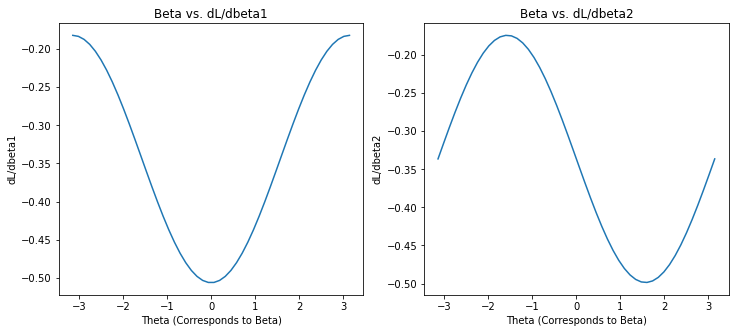

In [14]:
from scipy.stats import norm
def plot_expected_grad_loss_beta(agent_dist, sigma, f, true_beta=None, savefig=None):
    grad_beta1 = []
    grad_beta2 = []
    thetas = np.linspace(-np.pi, np.pi, 50)
    for theta in thetas:
        vec_beta = expected_gradient_loss_beta(agent_dist, theta, sigma, f, true_beta=None)
        grad_beta1.append(vec_beta[0].item())
        grad_beta2.append(vec_beta[1].item())

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    ax[0].plot(thetas, grad_beta1)
    ax[0].set_xlabel("Theta (Corresponds to Beta)")
    ax[0].set_ylabel("dL/dbeta1")
    ax[0].set_title("Beta vs. dL/dbeta1")
    ax[1].plot(thetas, grad_beta2)
    ax[1].set_xlabel("Theta (Corresponds to Beta)")
    ax[1].set_ylabel("dL/dbeta2")
    ax[1].set_title("Beta vs. dL/dbeta2")
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    plt.close()

plot_expected_grad_loss_beta(agent_dist, 0.35, f)
    

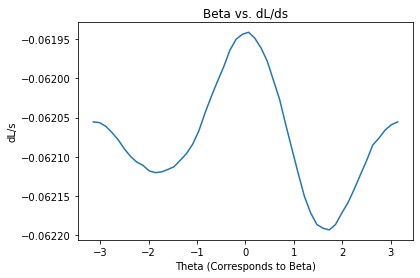

In [28]:
def plot_grad_loss_s(agent_dist, sigma, f, true_beta=None, savefig=None):
    grad_s = []
    thetas = np.linspace(-np.pi, np.pi, 50)
    for theta in thetas:
        d_l_d_s = expected_partial_loss_partial_s(agent_dist, theta, sigma, f, true_beta=None)
        grad_s.append(d_l_d_s)
    plt.plot(thetas, grad_s)
    plt.xlabel("Theta (Corresponds to Beta)")
    plt.ylabel("dL/s")
    plt.title("Beta vs. dL/ds")
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    plt.close()
    
plot_grad_loss_s(agent_dist, sigma, f)